<a href="https://colab.research.google.com/github/YahtzeeRage/cs480student/blob/main/06/Assignment_6_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

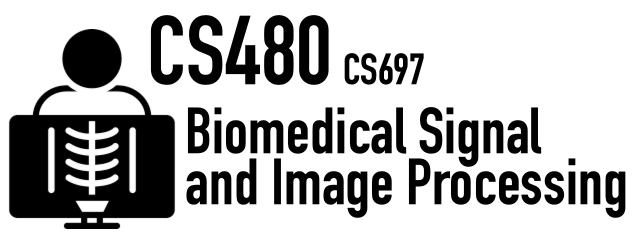
#Assignment 6

In [1]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [2]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-n8r11i9d
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-n8r11i9d
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=61d426d34279b898c92e49f4b2213423a0485a59afd1696457ea0aec2eadb003
  Stored in directory: /tmp/pip-ephem-wheel-cache-czdvp7po/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [5]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [6]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [7]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [8]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [9]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: U-Net is in this example, trained to take images with randomly placed circles on a noisy background and predict the segmentation
#       of the circles from th background.

In [10]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: circles.py creates images with randomly placed circles with added gaussian noise which are 1 channel images plus it makes
        # correspondingly labeled ground truth which are categorical datasets with two classes (segmentation and background) which when
        # arg-maxed can give white for circles and black for background. Thus U-Net can train to segment the noisy circles.py into circles 
        # and background+noise.

In [11]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: Mitochondria have the appearance of dark circles in the electron microscopy data

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [12]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [13]:
!curl https://cs480.org/data/mito.npz --output mito.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0   240M      0 --:--:-- --:--:-- --:--:--  240M


In [14]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        image = image / 255.0
        
        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)

        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [16]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [17]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# int(0.7*660)==461 so therefore 461 images (and corresponding 461 masks) are used for training alone

In [18]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [19]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [20]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model, train, val, test, epochs=50, batch_size=10)

Epoch 1/50
47/47 [==============================] - 62s 1s/step - loss: 0.6647 - categorical_crossentropy: 0.6647 - categorical_accuracy: 0.6105 - mean_iou: 0.2895 - dice_coefficient: 0.5279 - auc: 0.5727 - val_loss: 0.4800 - val_categorical_crossentropy: 0.4800 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3349 - val_dice_coefficient: 0.6222 - val_auc: 0.9817
Epoch 2/50
47/47 [==============================] - 40s 846ms/step - loss: 0.3021 - categorical_crossentropy: 0.3021 - categorical_accuracy: 0.9208 - mean_iou: 0.4439 - dice_coefficient: 0.8366 - auc: 0.9418 - val_loss: 0.3824 - val_categorical_crossentropy: 0.3824 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3714 - val_dice_coefficient: 0.6912 - val_auc: 0.9835
Epoch 3/50
47/47 [==============================] - 40s 848ms/step - loss: 0.3078 - categorical_crossentropy: 0.3078 - categorical_accuracy: 0.9210 - mean_iou: 0.4377 - dice_coefficient: 0.8241 - auc: 0.9378 - val_loss: 0.2034 - val_categorical_crossentropy

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [21]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

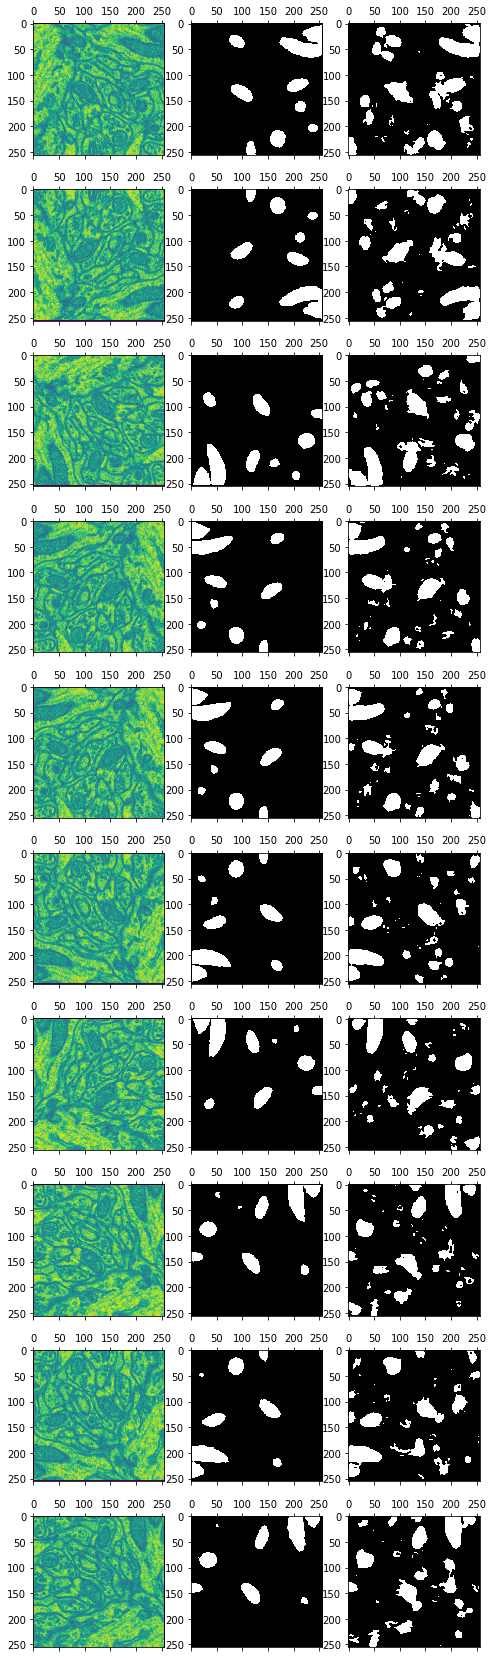

In [22]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [23]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: Categorical Machine Learning often uses the one-hot form for the predictions. In this case we get an output of 2 categories so the 
#       vector of predicted labels for each pixel should look something like this: [[a,b], [c,d]] and thus to get the predicted label at index
#       0 we have to turn prediction[0] or [a,b] into a value 0 or 1 corresponding to whether a or b is the larger value. This can be 
#       accomplished with prediction[0].argmax(axis=-1) which returns the index of the higher value a or b.

In [24]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: All things considered it is pretty good. There are almost no false negatives as there seems to be some representation for every
#       ground-truth labeled mitochondria. However one can immediately notice that there is all these false positives and noise in the 
#       image and holes in the mitochondria. As for image processing we could do some island removal and hole filling, this may make there be slightly more
#       false negatives but it would massively decrease the number of false positives in these noisy label maps as well as make the segmentations
#       more solid like we expect mitochondria to appear in the tissue. Mitochondria also tend to be very simple in shape and not very fine in 
#       features so another way we could reduce noise in the image would be to have a low pass filter for the image in the frequency space.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [25]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [26]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [40]:
unet_model.summary()
# learnable parameters: 31,030,658

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

In [28]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

In [29]:
# Casser et al. started off with an encoder+decoder number of parameters of 31,694,401. And with an encoder reduction of 94% and a
#    decoder reduction of 93.6% they found they could get the encoder+decoder parameters down to 2,356,960

In [30]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [31]:
# Casser et al. reduced the parameters by replacing transpose convolutional layers with bilinear upsampling layers which are lightweight
#    layers because they require no parameters.

In [32]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [33]:
# More parameters means training and predicting using the model will take more time and will require more memory consumption by the computer.
#     Because Casser et al. could do the same effective work or better with less parameters it was a massive improvement to performance of 
#     the model.

In [34]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#